# 0. Summary

1. The target is to predict the age of 100k linkedin users;
2. A optimized random forest model based on desiganted "ground truth" set and extracted features can have a reasonable prediction outcome;
3. 'startdate' might be a better feature source than 'enddate';
4. Combining the whole data sets (education, positions, seniority) before establishing models might be better than establishing models before combining them;
5. The text in 'major', education has potential to upgrade the prediction accuracy;
6. The text in 'jobtitle', positions has greater potential to upgrade the prediction accuracy;
7. From this draft, we can still improve our prediction in multiple aspects.

For prediction results, please check the "res.csv" file.

# 1. Objects Definitions & Core Assumptions

Before getting our hands dirty, we should define accurately what we want from these dataset:

## 1.1. Definitions
1. Profit goal: suppose we want to have a better understanding on users' age, so we can provide more accurate marketing/recommandation service strategies.
2. Age: Since we don't have exact age number and we need to create training set ourself, it's not reasonable to predict accurate age number from somehow randomly allocated age. Instead, age ranges are better choices.
   
   > Specifically, the definition of the 7 age ranges are:
   >
   > Label | range
   >
   >    1 | 18-24
   >
   >    2 | 24-30
   >
   >    3 | 30-36
   >
   >    4 | 36-42
   >
   >    5 | 42-48
   >
   >    6 | 48-54
   >
   >    7 | 54-60

   Starting at 18, stopping at 60 since I suppose the marketing target should be the population who is still active in job market.

   Besides, if the information in a row is too little to use, they will be grouped to "-1", which indicates "Don't know".

## 1.2. Aassumptions
1. The earliest reasonable education start date is a very good basis in determining a person's age;
2. The lowest acceptable degree is high school;
3. The starting age of a person's first degree is 14 (considering the first degree might be high school);
4. This means we only consider data points with starting points no earlier than 1976.1.1;
5. By inferring, the person's age should be in our target 7-range;
6. A person must have a reasonable 'major' (not "god", "budda", etc);
7. Lack of 'major' is acceptable if the time duration is "reasonable";
8. A "reasonable" time duration of a 'major" means no smaller than 6-month, and no bigger than 10-year (120-month) considering there are super short master's degree, various reasons to for gapping years, and phD's, etc.;
9. The education major text contains information about a person's age.
10. The job title text contians information about a person's age.

## 1.3. Furthermore

For 'major' in education dateset, we assume: 
1. All non-English 'major' will be regarded as translated already since I don't have the compuational power or time to actual translate them.

For 'jobtitle' in position dataset, we assume:
1. All problems in text which are similar to 'major' has been correctly coped with.

# 2. Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

import googletrans
from googletrans import Translator

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
education = pd.read_csv('education.csv')
seniority = pd.read_csv('jobtitle_seniority.csv')
position = pd.read_csv('positions.csv')

## 2.1.  Data Cleaning

Goal
1. Want 1 row/observation (removing duplications)
2. Most models cannot handle missing data (need to remove/fill)
3. Most models require fixed length feature vectors (engineer features)

## 2.2. Education Data

### 2.2.1. Check the original structure

In [3]:
education_copy = education.copy()
print(education_copy.info())
#education.iloc[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226184 entries, 0 to 226183
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    226184 non-null  object
 1   major      162346 non-null  object
 2   startdate  197556 non-null  object
 3   enddate    190658 non-null  object
dtypes: object(4)
memory usage: 6.9+ MB
None


### 2.2.2. Regulate the data type

In [4]:
#education_copy['user_id'] = education_copy['user_id'].astype(str)
education_copy['major'] = education_copy['major'].str.lower()
education_copy['major'] = education_copy['major'].str.replace('[^a-zA-Z\s]', ' ')
education_copy['startdate'] = pd.to_datetime(education_copy['startdate'])
education_copy['enddate'] = pd.to_datetime(education_copy['enddate'])
print(education_copy.info())
#education_copy.sort_values(['major']).iloc[:10]
education_copy.iloc[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226184 entries, 0 to 226183
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    226184 non-null  object        
 1   major      162346 non-null  object        
 2   startdate  197556 non-null  datetime64[ns]
 3   enddate    190658 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 6.9+ MB
None


,user_id,major,startdate,enddate
0,hqSv727UD4f0Cr8QyA8+8g5+2cvffV/mNepQVJd0smgtpB...,master of viticulture,2006-01-01,2008-01-01
1,hqSv727UD4f0Cr8QyA8+8g5+2cvffV/mNepQVJd0smgtpB...,bachelor of horticulture,2001-01-01,2005-01-01
2,hqSv727UD4f0Cr8QyA8+8g5+2cvffV/mNepQVJd0smgtpB...,wset level,2015-01-01,2015-01-01
3,hqSv727UD4f0Cr8QyA8+8g5+2cvffV/mNepQVJd0smgtpB...,graduated diploma,2008-01-01,2009-01-01
4,H2fZcOtCvd7DXFbzglIkpA5+2cvffV/mNepQVJd0smgtpB...,ling stica aplicada en la ense anza del ingl ...,2013-01-01,2016-01-01
5,H2fZcOtCvd7DXFbzglIkpA5+2cvffV/mNepQVJd0smgtpB...,licenciado en lenguas extranjeras,2005-01-01,2012-01-01
6,3VRjfXobf5CYummRNRjRlw5+2cvffV/mNepQVJd0smgtpB...,NaN,2012-01-01,2013-01-01
7,3VRjfXobf5CYummRNRjRlw5+2cvffV/mNepQVJd0smgtpB...,master of business administration m b a,2010-01-01,2015-01-01
8,shgvmeKu1Kqqi5LFqdMXsA5+2cvffV/mNepQVJd0smgtpB...,ba,2008-01-01,2012-01-01
9,shgvmeKu1Kqqi5LFqdMXsA5+2cvffV/mNepQVJd0smgtpB...,master s degree,2014-01-01,2016-01-01


### 2.2.3. Unreasonable data

According to our definitons and assumptions, there might be many unreasonable data:
1. Started education before80.1.1;
2. End date is earlier than start date;
3. Education duration is too long (>120-month or <6-month);
4. Major is rediculous (god, budda, king, president of US, etc.), this problem will be handled in feature engineering.

Drop started education before 1976.1.1

In [5]:
education_clean = education_copy[~(education_copy['startdate'] < '1976-01-01')]
#education_clean.sort_values(['startdate']).iloc[:10]
#print(education_clean.info())

Drop enddate > startdate OR education duration too long

In [6]:
education_clean['duration'] = education_clean['enddate'] - education_clean['startdate']
# suppose 1-month is 30-day
# and 1-year is 365-day
education_clean = education_clean[~(education_clean['duration'] < pd.Timedelta("180 days"))]
education_clean = education_clean[~(education_clean['duration'] > pd.Timedelta("3650 days"))]
#education_clean.sort_values(['duration']).iloc[:30]
#print(education_clean.info())

### 2.2.4. Duplication

It's reasonable for a person to have multiple educational experience. But completely identical education background is meaningless.

Let's check about it.

Drop duplications. Keep the first data if there are duplications.

In [7]:
education_dups = education_clean.drop_duplicates(subset=None, keep='first', inplace=False)
print(education_dups.shape)

(185502, 5)


### 2.2.5. Missing Data

Missing data here can be tricky. There are several ways to deal with it:
1. Drop rows;
2. Impute from data in the same column
3. Infer from other features
4. Fill with adjacent data

For 'major' and 'date', impute, infer, and fill are all meaningless. So we drop. Dropping is easy to do and simple to understand. But we may face potentially large data loss.

But I summarized some cases:
1. If only 'major' is missing, we can stand it since the 'startdate' and 'enddate' may still reveal information about one's educational status.
2. If only one of 'startdate' or 'enddate' is missing, wo do not drop since one's education may still undergo.
3. If 'major' remains, but 'startdate' and/or 'enddate' are/is missing, we do not drop since the 'major' may still reveal information about one'e educational history.

In a word, we drop when:
1. Every thing is missing;
2. 'major', 'startdate', and 'enddate' are all NA.

Also, a reasonable assumption of end date is, if the end date is NA, we regard it as still ongoing, so we set it to today's date.

Before dropping, let's check the data loss first:

In [8]:
print(education_dups.isna().sum())
print(education_dups.isna().sum().sum())

user_id          0
major        49249
startdate    24651
enddate      30784
duration     32182
dtype: int64
136866


In [9]:
print(education_dups.dropna(subset=['major', 'startdate', 'enddate'], thresh=2).shape)

(159465, 5)


Acceptable, we still have almost 160k rows.

In [10]:
education_dups_na = education_dups.dropna(subset=['major', 'startdate', 'enddate'], thresh=2)

Fill all nan major to placeholder

In [11]:
education_dups_na.major.fillna('placeholder', inplace=True)

### 2.2.6. Split datetime to year/month/day:

A common preprocessing to deal with datetime is to split them into y/m/d.

In [12]:
education_dups_na["start_year"] = education_dups_na['startdate'].map(lambda x: x.year)
education_dups_na["start_month"] = education_dups_na['startdate'].map(lambda x: x.month)
education_dups_na["start_day"] = education_dups_na['startdate'].map(lambda x: x.day)

education_dups_na["end_year"] = education_dups_na['enddate'].map(lambda x: x.year)
education_dups_na["end_month"] = education_dups_na['enddate'].map(lambda x: x.month)
education_dups_na["end_day"] = education_dups_na['enddate'].map(lambda x: x.day)

education_dups_na_split = education_dups_na

#print(education_dups_na_split.info())

In [13]:
education_new = education_dups_na_split
#education_new.sort_values('startdate')

## 2.3. Seniority Data

### 2.3.1. Check the original structure

In [14]:
seniority_copy = seniority.copy()
print(seniority_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416295 entries, 0 to 416294
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    416295 non-null  object 
 1   jobtitle   414290 non-null  object 
 2   seniority  416295 non-null  float64
dtypes: float64(1), object(2)
memory usage: 9.5+ MB
None


### 2.3.2. Duplication
There is no duplication.

In [15]:
print(seniority_copy[seniority_copy.duplicated(keep=False)].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    0 non-null      object 
 1   jobtitle   0 non-null      object 
 2   seniority  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes
None


### 2.3.3. Missing Data

In [16]:
print(seniority_copy.isna().sum())
print(seniority_copy.isna().sum().sum())

user_id         0
jobtitle     2005
seniority       0
dtype: int64
2005


NAs only appears in 'jobtitle'. We can still get information from the seniority numbers. So we keep all the original data.

In [17]:
seniority_new = seniority_copy

## 2.4. Position Data

### 2.4.1. Check the original structures:

In [18]:
position_copy = position.copy()
print(position_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377585 entries, 0 to 377584
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    377585 non-null  object
 1   jobtitle   376136 non-null  object
 2   startdate  368526 non-null  object
 3   enddate    270354 non-null  object
dtypes: object(4)
memory usage: 11.5+ MB
None


### 2.4.2. Regulate the data type:

In [19]:
#position_copy['user_id'] = position_copy['user_id'].astype(str)
#position_copy['jobtitle'] = position_copy['jobtitle'].astype(str).str.lower()
position_copy['startdate'] = pd.to_datetime(position_copy['startdate'])
position_copy['enddate'] = pd.to_datetime(position_copy['enddate'])
#print(position_copy.info())
#position_copy.iloc[:30]

### 2.4.3. Unreasonable Data

A job can not start before 1976.1.1

In [20]:
position_clean = position_copy[~(position_copy['startdate'] < '1976-01-01')]
#print(position_clean.info())
#position_clean.sort_values(['startdate']).iloc[:10]

Suppose a job at least last for 30 days, last no more than 60-year (since 'jobtitle' can be like 'owner')

In [21]:
position_clean['duration'] = position_clean['enddate'] - position_clean['startdate']
# suppose 1-month is 30-day
# and 1-year is 365-day
position_clean = position_clean[~(position_clean['duration'] < pd.Timedelta("30 days"))]
position_clean = position_clean[~(position_clean['duration'] > pd.Timedelta("21600 days"))]
#position_clean.sort_values(['user_id', 'duration'], ascending=False).iloc[:30]
#print(position_clean.info())

### 2.4.4. Duplications

In [22]:
print(position_copy[position_copy.duplicated(keep=False)].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    0 non-null      object        
 1   jobtitle   0 non-null      object        
 2   startdate  0 non-null      datetime64[ns]
 3   enddate    0 non-null      datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 0.0+ bytes
None


There is no duplication.

### 2.4.5. Missing Data

Similar to education data, for 'jobtitle' and 'date', impute, infer, and fill are all meaningless. So we drop. Dropping is easy to do and simple to understand. But we may face potentially large data loss.

Summarized some cases:
1. If only 'jobtitle' is missing, we can stand it since the 'startdate' and 'enddate' may still reveal information about one's educational status.
2. If only one of 'startdate' or 'enddate' is missing, wo do not drop since one's education may still undergo.
3. If 'jobtitle' remains, but 'startdate' and/or 'enddate' are/is missing, we do not drop since the 'jobtitle' may still reveal information about one'e educational history.

In a word, we drop when:
1. Every thing is missing;
2. 'jobtitle', 'startdate', and 'enddate' are all NA.

In [23]:
print(position_copy.isna().sum())
print(position_copy.isna().sum().sum())

user_id           0
jobtitle       1449
startdate      9059
enddate      107231
dtype: int64
117739


Still got almost 370k data. Acceptable.

In [24]:
print(position_copy.dropna(subset=['jobtitle', 'startdate', 'enddate'], thresh=2).shape)
position_na = position_copy.dropna(subset=['jobtitle', 'startdate', 'enddate'], inplace=False, thresh=2)
print(position_na.shape)
position_new = position_na

(368297, 4)
(368297, 4)


## 2.5. Combine 3 tables based on user_id

### 2.5.1. Draw information from education

In [25]:
set1 = set(education_new.loc[:, 'user_id'])
#print(len(set1))
set2 = set(seniority_new.loc[:, 'user_id'])
#print(len(set2))
set3 = set(position_new.loc[:, 'user_id'])
#print(len(set3))
id_set = set1 | set2 | set3

linkedin = pd.DataFrame(data={'user_id': pd.Series(list(id_set))})

In [26]:
# Find the number of education of each user_id
cnt = education_new.groupby('user_id').count().major

# Find earliest startdate/enddate and latest startdate/enddate
earliest_learn = education_new.sort_values('startdate').groupby('user_id').head(1).sort_index()[['user_id', 'startdate']]
latest_learn = education_new.sort_values('startdate').groupby('user_id').tail(1).sort_index()[['user_id', 'startdate']]
earliest_grad = education_new.sort_values('enddate').groupby('user_id').head(1).sort_index()[['user_id', 'enddate']]
latest_grad = education_new.sort_values('enddate').groupby('user_id').tail(1).sort_index()[['user_id', 'enddate']]
earliest_learn = earliest_learn.rename(columns={'startdate': 'earliest_learn'})
earliest_grad = earliest_grad.rename(columns={'enddate': 'earliest_grad'})
latest_learn = latest_learn.rename(columns={'startdate': 'latest_learn'})
latest_grad = latest_grad.rename(columns={'enddate': 'latest_grad'})

# merge counts into user_id
linkedin = pd.merge(linkedin, cnt, left_on='user_id', right_index=True, how='left')

# merge dates into user_id
linkedin = pd.merge(linkedin, earliest_learn, left_on='user_id', right_on='user_id', how='left')
linkedin = pd.merge(linkedin, earliest_grad, left_on='user_id', right_on='user_id', how='left')
linkedin = pd.merge(linkedin, latest_learn, left_on='user_id', right_on='user_id', how='left')
linkedin = pd.merge(linkedin, latest_grad, left_on='user_id', right_on='user_id', how='left')

linkedin = linkedin.rename(columns={'major': 'edu_cnt'})

### 2.5.2. Draw information from position

In [27]:
# Find the number of experience of each user_id
cnt = position_new.groupby('user_id').count().jobtitle

# Find earliest startdate/enddate and latest startdate/enddate
earliest_learn = position_new.sort_values('startdate').groupby('user_id').head(1).sort_index()[['user_id', 'startdate']]
latest_learn = position_new.sort_values('startdate').groupby('user_id').tail(1).sort_index()[['user_id', 'startdate']]
earliest_grad = position_new.sort_values('enddate').groupby('user_id').head(1).sort_index()[['user_id', 'enddate']]
latest_grad = position_new.sort_values('enddate').groupby('user_id').tail(1).sort_index()[['user_id', 'enddate']]
earliest_learn = earliest_learn.rename(columns={'startdate': 'earliest_work'})
earliest_grad = earliest_grad.rename(columns={'enddate': 'earliest_quit'})
latest_learn = latest_learn.rename(columns={'startdate': 'latest_work'})
latest_grad = latest_grad.rename(columns={'enddate': 'latest_quit'})

# merge counts into user_id
linkedin = pd.merge(linkedin, cnt, left_on='user_id', right_index=True, how='left')

# merge dates into user_id
linkedin = pd.merge(linkedin, earliest_learn, left_on='user_id', right_on='user_id', how='left')
linkedin = pd.merge(linkedin, earliest_grad, left_on='user_id', right_on='user_id', how='left')
linkedin = pd.merge(linkedin, latest_learn, left_on='user_id', right_on='user_id', how='left')
linkedin = pd.merge(linkedin, latest_grad, left_on='user_id', right_on='user_id', how='left')

linkedin = linkedin.rename(columns={'jobtitle': 'job_cnt'})

### 2.5.3. Draw information from seniority

<AxesSubplot:xlabel='seniority'>

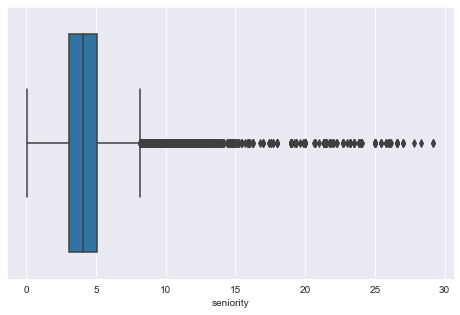

In [28]:
plt.figure(figsize=(8,5))
sns.boxplot(seniority_new['seniority'])

In [29]:
# Find the number of experience of each user_id
cnt = seniority_new.groupby('user_id').count().seniority

# merge counts into user_id
linkedin = pd.merge(linkedin, cnt, left_on='user_id', right_index=True, how='left')

# draw some features from seniority
seni_avg = seniority_new.groupby('user_id').mean()
seni_max = seniority_new.groupby('user_id').max()
seni_min = seniority_new.groupby('user_id').min()
seni_sum = seniority_new.groupby('user_id').sum()
seni_mid = seniority_new.groupby('user_id').median()
seni_avg = seni_avg.rename(columns={'seniority': 'seni_avg'})
seni_max = seni_max.rename(columns={'seniority': 'seni_max'})
seni_min = seni_min.rename(columns={'seniority': 'seni_min'})
seni_sum = seni_sum.rename(columns={'seniority': 'seni_sum'})
seni_mid = seni_mid.rename(columns={'seniority': 'seni_mid'})

# merge
linkedin = pd.merge(linkedin, seni_avg, left_on='user_id', right_index=True, how='left')
linkedin = pd.merge(linkedin, seni_max, left_on='user_id', right_index=True, how='left')
linkedin = pd.merge(linkedin, seni_min, left_on='user_id', right_index=True, how='left')
linkedin = pd.merge(linkedin, seni_sum, left_on='user_id', right_index=True, how='left')
linkedin = pd.merge(linkedin, seni_mid, left_on='user_id', right_index=True, how='left')


linkedin = linkedin.rename(columns={'seniority': 'seni_cnt'})

### 2.5.4. Drop some column to make the complete cases more

If we do not drop, there will be too few of complete training set.

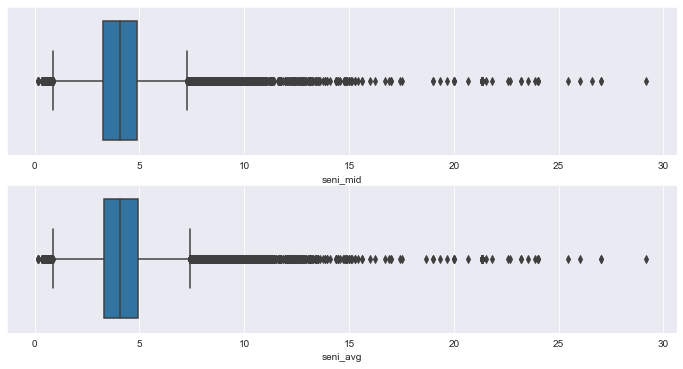

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

i = 0
for col in ['seni_mid', 'seni_avg']:
    sns.boxplot(linkedin[col], ax=ax[i])
    i += 1

In [31]:
print(linkedin.isna().sum())
print(linkedin.isna().sum().sum())

user_id               0
edu_cnt           13929
earliest_learn    14631
earliest_grad     15927
latest_learn      14801
latest_grad       18067
job_cnt           20824
earliest_work     20825
earliest_quit     31934
latest_work       20869
latest_quit       90150
seni_cnt              0
seni_avg              0
seni_max              0
seni_min              0
seni_sum              0
seni_mid              0
dtype: int64
261957


In [32]:
linkedin = linkedin.drop(['earliest_quit', 'latest_quit', 'seni_avg'], axis=1)

### 2.5.5. Convert Dates to date difference

In [33]:
# calculate the difference between dates and today as years
cols = ['earliest_learn', 'earliest_grad', 'latest_learn', 'latest_grad', 'earliest_work', 'latest_work']

for col in cols:
    linkedin[col+'_diff'] = (pd.to_datetime("today") - linkedin[col]) / np.timedelta64(1, 'Y')

# linkedin['earliest_learn_diff'] = (pd.to_datetime("today") - linkedin['earliest_learn']) / np.timedelta64(1, 'Y')
# linkedin['latest_grad_diff'] = (pd.to_datetime("today") - linkedin['latest_grad']) / np.timedelta64(1, 'Y')
# linkedin['earliest_work_diff'] = (pd.to_datetime("today") - linkedin['earliest_work']) / np.timedelta64(1, 'Y')

#linkedin

# 3. Create Training Sets
Find education words frequency

Since we need to find training data ourself, we need an independent (or, at least as independent as possible) mechanism compaing with the preiction model to avoid "predict what we made up".

To make our prediction model as reasonable as possible, we should create our training label as accurate as possible. Let's check our options first.

We have 3 original datasets:
1. seniority: the numbers of seniority doesn't seems like an linear function of job durations. A reasonable guess could be the results from the job description via NLP models. Although this dataset can reveal information combined with other data, this alone can not be a good basis to create a training set. It should be aligned with other data;
2. position: position can be a reasonable basis to create training set. For example, we cna find the earliest start date of all jobs of a person and make our training labels by addition. However, it's still not optimal in our case since it can be tricky to distinguish the type of jobs (par-time, intern, full-time, etc.) and evaluate the time sequences among jobs and educations.
3. education: this is the optimal choice in our case. A person can have multiple types of jobs in various age range, but, in general, most people will earn their degress while they are still young (for example, most of students start college at 18).

So, the most reasonable choice in creation of training set is to utilize the education data.

However, many specific question remains:
1. What marks should we rely on?
2. Which date should we utilize?
3. How many data should we draw?
4. How can we make sure that the data & model in creating training set is independent to the data & model we use to predict?
5. How to make sure that the numbers of data on each age range are balanced (approximately with the same number of rows)?
6. How to make sure that the training set is sufficient for prediction model training (does training set contains enough original informations)?

Let's check what can we find from the original data first:

> Top 10 token frequence of 'major'

<AxesSubplot:>

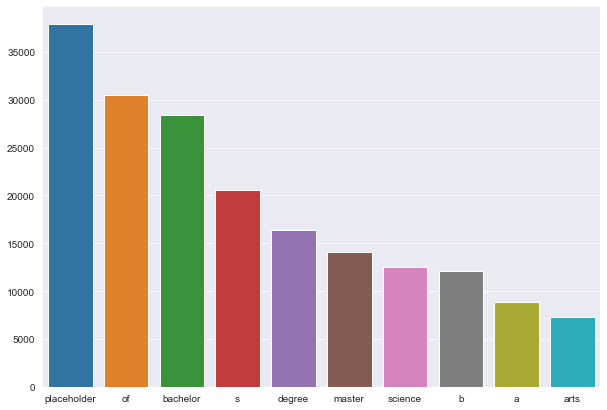

In [34]:
top10words = education_new.major.str.split(expand=True).stack().value_counts()[:10]
#print(top10words)
plt.figure(figsize=(10,7))
sns.barplot(top10words.index, top10words)

It turns out that we have at least 20054 + 7315 = 27369 data points which indicate the degree is 'bachelor' (if counting the abbriviation like BSc, BA, etc., there will be more).

This could be a good basis since
1. most people start their bachelor's degree at a certian age (18);
2. we have enough data (up to 27369) for training purpose;
3. although the enddata can vary since some people may take gap year(s) or drop from school, we can rely on start date, which is much more accurate;
4. even though we may take up to about 27k data from the original data set to make train/prediction independent, we still have over about 100k data which we can run our prediction model on;
5. the creation of training sample is effcient and reasonable and with the highest accuracy comparing with other options: we simply suppose the year of a 'bachelor's' start date is of age 18, then calculate the difference between that age and today, then add 18 to this difference;
6. we can select the user_id(s) with complete information on all 3 original tables to make sure our prediction model can draw as much as information from as many features as possible from these traning points;
7. we can efficiently make the numbers of age-range balanced.

In [35]:
bachelors = education_new.loc[education_new['major'].str.contains("bachelor", case=False)]
#bachelors

In [36]:
# pick bachelors from education data
bachelors = education_new.loc[education_new['major'].str.contains("bachelor", case=False)]
bachelors['bc_learn'] = bachelors.startdate
bachelors = bachelors[['user_id', 'bc_learn']]

# join to big table
linkedin = pd.merge(linkedin, bachelors, left_on='user_id', right_on='user_id', how='left')
#linkedin
#linkedin.bc_learn = linkedin.bc_learn.fillna(False)

In [37]:
linkedin = linkedin.drop_duplicates(keep='first', inplace=False, subset='user_id')

In [38]:
bc_df = linkedin.loc[~linkedin.bc_learn.isnull()]
completes = bc_df[~linkedin.isnull().any(axis=1)]
completes['birth_guess'] = completes['bc_learn'] + pd.offsets.DateOffset(years=-18)
completes['age_guess'] = ((pd.to_datetime("today") - completes['birth_guess']) / np.timedelta64(1, 'Y'))
#completes

In [39]:
def label_age(x):
   if x <=24:
      return 1
   if 24 < x <= 30:
      return 2
   if 30 < x <= 36:
      return 3
   if 36 < x <= 42:
      return 4
   if 42 < x <= 48:
      return 5
   if 48 < x <= 54:
      return 6
   if x > 54:
      return 7
   return 0

In [40]:
completes['label'] = completes.age_guess.apply(lambda x: label_age(x))
#completes.sort_values('age_guess')
completes_copy = completes.copy()

cols = [col + '_diff' for col in cols]
completes = completes[['user_id'] + cols + ['edu_cnt', 'seni_cnt', 'seni_max', 'seni_min', 'seni_sum', 'seni_mid', 'label']]
#completes.sort_values('label')

Text(0, 0.5, 'Number of Samples')

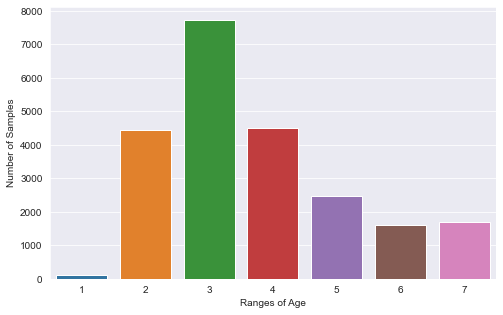

In [41]:
cnt = completes.label.value_counts()
plt.figure(figsize=(8,5))
sns.barplot(cnt.index, cnt)
plt.xlabel('Ranges of Age')
plt.ylabel('Number of Samples')

Very unbalanced data. We might need to use naive resampling (under/over sampling combined) in the training parts from cross validation.

The using of rebalancing methods should be based on the final performance since random sampling may affect the generaliztion ability. For time-limit and computational-power-limit, I choose to only run model on the rebalanced data sets.

# 4. Select Models for the Number-Based Predictions (heavily commented for faster rendering)

## 4.1. Try multiple models of almost default parameters

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

In [43]:
# define dataset and summarize class distribution
X, y = completes.iloc[:, 1:-1], completes.iloc[:, -1]
#print(Counter(y))
#X = StandardScaler().fit_transform(X)
#print(X)

# define over/under sampling strategy
over_stra = {1: 1000, 6: 2000, 7: 2000}
under_stra = {3: 5000}
#over = RandomOverSampler(sampling_strategy=over_stra)
#under = RandomUnderSampler(sampling_strategy=under_stra)

# # fit and apply the transform
# X, y = over.fit_resample(X, y)
# print(Counter(y))
# X, y = under.fit_resample(X, y)
# print(Counter(y))



names = [
    #"Nearest Neighbors",
    #"Linear SVM",
    #"RBF SVM",
    #"Gaussian Process",
    #"Logistics",
    "Decision Tree",
    "Random Forest",
    #"Neural Net",
    #"AdaBoost",
    #"Naive Bayes",
    #"QDA",
]

classifiers = [
    #KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #LogisticRegression(solver='liblinear'),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
]

#for rs in range(1, 5):
#for rs in range(1, 1):
    #print('Entering random_state: ', rs)

# for reproductivity
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)

# find the best by F1
best_name = ''
best_f1 = -1
best_std = 0

# evaluate models
for i in range(len(names)):
    # define pipeline
    steps = [('over', RandomOverSampler(sampling_strategy=over_stra)), ('under', RandomUnderSampler(sampling_strategy=under_stra)), ('model', classifiers[i])]
    pipeline = Pipeline(steps=steps)

    # evaluate pipeline
    scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
    score = np.mean(scores)    
    print('F1 Score of ' + names[i] + ': %.3f' % score)
    print(f'{score :0.2f} +- {2*np.std(scores) :0.2f}')
    
    # update best model
    if score > best_f1:
        best_name = names[i]
        best_f1 = score
        best_std = np.std(scores)

# show the best model and its performance
print('Best F1 Score from ' + best_name + ': %.2f' % best_f1)
print(f'{best_f1 :0.2f} +- {2*best_std :0.2f}')

# # define pipeline
# steps1 = [('over', RandomOverSampler(sampling_strategy=over_stra)), ('under', RandomUnderSampler(sampling_strategy=under_stra)), ('model', DecisionTreeClassifier())]
# pipeline1 = Pipeline(steps=steps1)
# steps2 = [('over', RandomOverSampler(sampling_strategy=over_stra)), ('under', RandomUnderSampler(sampling_strategy=under_stra)), ('model', LogisticRegression(solver='liblinear'))]
# pipeline2 = Pipeline(steps=steps2)

# # evaluate pipeline
# scores_tree = cross_val_score(pipeline1, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
# score_tree = np.mean(scores_tree)
# print('F1 Score: %.3f' % score_tree)
# scores_log = cross_val_score(pipeline2, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
# score_log = np.mean(scores_tree)
# print('F1 Score: %.3f' % score_log)



F1 Score of Decision Tree: 0.825
0.83 +- 0.02
F1 Score of Random Forest: 0.798
0.80 +- 0.02
Best F1 Score from Decision Tree: 0.83
0.83 +- 0.02


Classification tree, random forest, and neural network are possible choices. 

## 4.2. Optimization: Classification Tree

In [44]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)

# for _ in range(10):
#     mean_scores = []
#     for depth in [8, 9, 10, 11, 12, 13, 14]:
#         steps = [('over', RandomOverSampler(sampling_strategy=over_stra)), ('under', RandomUnderSampler(sampling_strategy=under_stra)), ('model', DecisionTreeClassifier(max_depth=depth))]
#         pipeline = Pipeline(steps=steps)
#         scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
#         score = np.mean(scores).round(3)
#         mean_scores.append( (depth, score) )
#     # for depth, mean_score in mean_scores:
#     #     print(f'{depth = :2d} : {mean_score: 0.3f}')

#     print(sorted(mean_scores, key=lambda x:x[1],reverse=True)[0])

The best depth is 9 by cross validation.

## 4.3. Optimization: Random Forest

In [45]:
# from sklearn.model_selection import GridSearchCV

# params = {'model__bootstrap': [True, False],
#                 'model__max_depth': [5, 10, 30],
#                 'model__max_features': ['auto', 'sqrt'],
#                 'model__min_samples_leaf': [1, 2, 4],
#                 'model__min_samples_split': [2, 5, 10],
#                 'model__n_estimators': [10, 50, 80]}

# steps = [('over', RandomOverSampler(sampling_strategy=over_stra)), ('under', RandomUnderSampler(sampling_strategy=under_stra)), ('model', RandomForestClassifier())]
# pipeline = Pipeline(steps=steps)
# rf_search = GridSearchCV(pipeline, param_grid=params, refit=True, n_jobs=-1, scoring='f1_micro') # refit True trains one more time on the entire training set

# rf_search.fit(X,y)
# print("Best parameter (CV score=%0.3f):" % rf_search.best_score_)
# print(rf_search.best_params_)


The best RF is:
{'model__bootstrap': False, 'model__max_depth': 30, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 50}

## 4.4. Optimization: Neural Network

In [46]:
# #MLPClassifier(alpha=1, max_iter=1000)
# params = {'model__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#             'model__activation': ['tanh', 'relu'],
#             'model__solver': ['sgd', 'adam'],
#             'model__alpha': [0.0001, 0.05, 1],
#             'model__learning_rate': ['constant','adaptive'], 
#             }

# steps = [('over', RandomOverSampler(sampling_strategy=over_stra)), ('under', RandomUnderSampler(sampling_strategy=under_stra)), ('model', MLPClassifier(max_iter=1000))]
# pipeline = Pipeline(steps=steps)
# rf_search = GridSearchCV(pipeline, param_grid=params, refit=True, n_jobs=11, scoring='f1_micro') # refit True trains one more time on the entire training set

# rf_search.fit(X,y)
# print("Best parameter (CV score=%0.3f):" % rf_search.best_score_)
# print(rf_search.best_params_)


Best parameter (CV score=0.825):
{'model__activation': 'tanh', 'model__alpha': 0.05, 'model__hidden_layer_sizes': (50, 100, 50), 'model__learning_rate': 'constant', 'model__solver': 'adam'}

So a reasonable choice is to use random forest with the parameters above.

## 4.5. Train Optimal Random Forest on The Training Set as a Whole

In [47]:
# pick data
X, y = completes.iloc[:, 1:-1], completes.iloc[:, -1]

# set the random sampler
over_stra = {1: 1000, 6: 2000, 7: 2000}
under_stra = {3: 5000}
over = RandomOverSampler(sampling_strategy=over_stra)
under = RandomUnderSampler(sampling_strategy=under_stra)

# fit and apply the transform
X, y = over.fit_resample(X, y)
print(Counter(y))
X, y = under.fit_resample(X, y)
print(Counter(y))

clf = RandomForestClassifier(bootstrap=False, max_depth=30, max_features='auto', min_samples_leaf=1, min_samples_split=5, n_estimators=50)
clf.fit(X, y)

Counter({3: 7732, 4: 4493, 2: 4432, 5: 2485, 6: 2000, 7: 2000, 1: 1000})
Counter({3: 5000, 4: 4493, 2: 4432, 5: 2485, 6: 2000, 7: 2000, 1: 1000})


RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=50)

# 5. Filling NAs for Broader Prediction

To deal with the NA, we have several options.
1. Drop all incomplete;
2. Fill with interpolation;
3. Fill with min/max;
4. Fill with constant values;
5. Fill with inpute (average).

If we drop all, then we can not predict most of the users;

We can not fill with interpolation since the values have no order;

Filling with min/max would push our predictions to one extream;

We don't know what kind of constant value should be filled without affecting our model;

As shown in the (true) age distribution bar chart above, if we are not sure about a certain information field of a person, a reasonable guess (a dummy guess in the meantime) should be the this person is of the average age of the sample space. So, by setting the NAs to the avg, we have somehow set a dummy prediction direction of our random forest model: if you are not sure, move this person close to the average (or median) position. In our case, the average postion should be age group 3 (30 - 36), which is a pretty good guess regarding the reality.

In [48]:
linkedin_impute = linkedin.copy()
linkedin_impute = linkedin_impute.drop(['earliest_learn', 'earliest_grad', 'latest_learn', 'latest_grad', 'earliest_work', 'latest_work', 'bc_learn'], axis=1)
linkedin_impute = linkedin_impute[['user_id'] + cols + ['edu_cnt', 'seni_cnt', 'seni_max', 'seni_min', 'seni_sum', 'seni_mid']]
#print(linkedin_impute.info())

In [49]:
for name, _ in linkedin_impute.iteritems():
    if name == 'user_id':
        continue
    linkedin_impute[name].fillna(linkedin_impute[name].mean(),inplace=True)

# 6. Predict Age Range by Optimal Random Forest Function

In [50]:
rf_predict = clf.predict(linkedin_impute.iloc[:, 1:])
#len(rf_predict)

# 7. Exploration: NLP on Education 'major'

I suppose the education background, order by the startdate, has some long-term structure underneath. So LSTM might be a good try-out in the first place.

Unfortunately, after trying out many combinations of accuracy optimiaztion technologies, based on the current data amount we have, we can only achieve about 0.2 accuracy. So the process below is to show what could we might achieve if we have extra time and data via LSTM.

Before we go on with NLP model, we should clean our text first. Here are some problems I observed:
1. There are differences in lower/upper cases
2. There are strange symbols like "_" in the text
3. There are digits in text
4. There are abbreviations (mba, phd, ...);
5. There are wrong spelling (bachelor/bechelor)
6. There are non-English text;
7. There are unreasonable major ('god', 'king', ...);
8. ......

1 to 3 has been addressed in the previous cleaning.
Here, I only tried address 4, 5, and 6 as a demonstration of cleaning, since there is time limit.
6 (find the "dirty words") can be very time consuming.

In [51]:
# pick the major text data
majors = education_new[['user_id', 'major', 'startdate']].copy()

## 7.1. Replace Abbreviations

Notice that I random over sampling the data (x100) to make the accuracy reached about 0.43. With the original data, even with very complicated network, we can only reach about 0.3 on test set.

In [52]:
import re

# set up reg expressions
hs = '((^|\s)hs($|\s))'
bc = ['ba', 'bb', 'bd', 'bfa', 'bm', 'bs', 'bsc', 'db', 'llb', 'musb', 'phb', 'sb', 'stb', 'bechelor']
ms = ['edm', 'llm', 'ma', 'mba', 'mdiv', 'med', 'mfa', 'mlis', 'mm', 'mmus', 'mpa', 'mphil', 'ms', 'msc', 'msci', 'msis', 'msn', 'msw', 'mt', 'sm', 'scm', 'mha', 'mpa', 'mester']
phd = ['dc', 'dd', 'dds', 'dlitt', 'dlit', 'dma', 'dmd', 'dmin', 'dvm', 'edd', 'jd', 'lhd', 'littd', 'md', 'phd']

pre = '((^|\s)'
suf = '($|\s))'

bc = [pre + abb + suf for abb in bc]
ms = [pre + abb + suf for abb in ms]
phd = [pre + abb + suf for abb in phd]
    
bc = '|'.join(bc)
ms = '|'.join(ms)
phd = '|'.join(phd)

# replace abbreviations
regs = [hs, bc, ms, phd]
to_str = [' high school ', ' bachelor ', ' master ', ' doctor ']
for i in range(len(regs)):
    majors.major.replace(regs[i], to_str[i], regex=True, inplace=True)

## 7.2. Translate

Since there are text not in English, tried to use Google Translate API to translate the text first. But it's too slow: I need around 20h to complete the translation.

So here, I just show a mini set of data to show the process.

In [53]:
translator = Translator()
#translation = translator.translate("auslandssemester", dest='en')
#print(translation.text)

# select a small set of data
#atest = education_clean['major'].iloc[:5].apply(translator.translate, dest='en').apply(getattr, args=('text',))
tmp = majors.iloc[:10]

# detect the language
langs = tmp.major.apply(translator.detect).apply(getattr, args=('lang', ))
tmp['langs'] = langs
#print(langs)
#education_clean['major_trans'] = education_clean['major'].apply(translator.translate, dest='en').apply(getattr, args=('text',))
#education_clean.sort_values(['duration']).iloc[:30]
#print(tmp)

# translate them to english
other_lang = tmp.loc[tmp.langs != 'en']
test_res = other_lang['major'].apply(translator.translate, dest='en').apply(getattr, args=('text',))
print(test_res)

4    Linguistics applied in the teaching of English...
5                        Bachelor of Foreign Languages
Name: major, dtype: object


## 7.3. Remove 'placeholder', which was prepared for translation

In [54]:
majors.major.replace('placeholder', '', regex=True, inplace=True)

## 7.4. Explore the Word Sets

In [55]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

## 7.5. Select the Training Set We Used in Random Forest

In [56]:
train_id = completes['user_id'].copy()
edu_nlp_train = majors[majors['user_id'].isin(train_id)]
edu_nlp_train.sort_values(['user_id', 'startdate'], inplace=True)
edu_nlp_train = edu_nlp_train.copy()
edu_nlp_train['words'] = edu_nlp_train.groupby('user_id').transform(lambda x: ''.join(x))
edu_nlp_train.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [57]:
edu_nlp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22576 entries, 5126 to 185119
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    22576 non-null  object        
 1   major      22576 non-null  object        
 2   startdate  22576 non-null  datetime64[ns]
 3   words      22576 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 881.9+ KB


In [58]:
edu_nlp_train['totalwords'] = edu_nlp_train['words'].str.split().str.len()
#edu_nlp_train

## 7.6. Check the results of cleaning

3951


<AxesSubplot:>

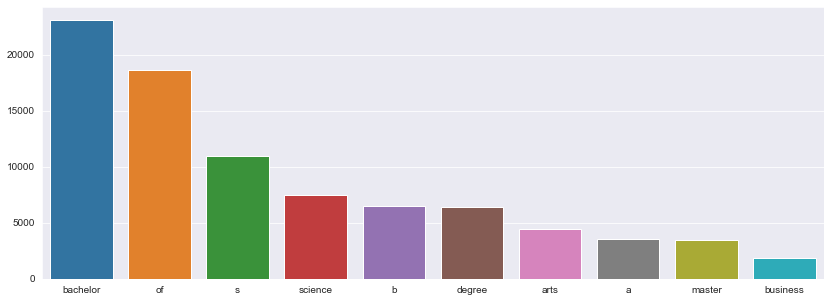

In [59]:
words_count = edu_nlp_train.words.str.split(expand=True).stack().value_counts()
print(len(words_count))
#print(top10words)
top10words = words_count[:10]
plt.figure(figsize=(14,5))
sns.barplot(top10words.index, top10words)

count    22576.000000
mean         5.273521
std          2.867668
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         34.000000
Name: totalwords, dtype: float64


Text(0.5, 1.0, 'Majors Words Conbined By Startdate')

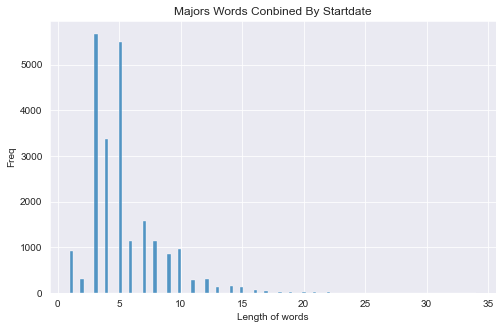

In [60]:
print(edu_nlp_train.totalwords.describe())
plt.figure(figsize=(8, 5))
sns.histplot(edu_nlp_train.totalwords)
plt.xlabel("Length of words")
plt.ylabel("Freq")
plt.title("Majors Words Conbined By Startdate")

In [61]:
# join the training set
labels = completes[['user_id', 'label']]
edu_nlp_train = pd.merge(edu_nlp_train, labels, left_on='user_id', right_on='user_id', how='left')

## 7.7. Draw some train/val/test

In [62]:
from sklearn.model_selection import train_test_split

# define dataset and summarize class distribution
X, y = edu_nlp_train[['user_id', 'words']], edu_nlp_train.iloc[:, -1]
#print(Counter(y))
#X = StandardScaler().fit_transform(X)
#print(X)

# define over/under sampling strategy
over_stra = {1: 1000, 6: 2000, 7: 2000}
under_stra = {3: 5000}
over = RandomOverSampler(sampling_strategy=over_stra)
under = RandomUnderSampler(sampling_strategy=under_stra)

# fit and apply the transform
X, y = over.fit_resample(X, y)
#print(Counter(y))
X, y = under.fit_resample(X, y)
#print(Counter(y))

# increase the data volumn
over_stra = {1: 100000, 2: 443200, 3: 500000, 4: 449300, 5: 248600, 6: 200000, 7: 200000}
over = RandomOverSampler(sampling_strategy=over_stra)
X, y = over.fit_resample(X, y)
print(Counter(y))

# split to trian/val/test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.25, random_state=1)

Counter({3: 500000, 4: 449300, 2: 443200, 5: 248600, 6: 200000, 7: 200000, 1: 100000})


## 7.8. Encoding labels

In [63]:
# reshape
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
val_y = le.transform(val_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

# one-hot
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
val_y = ohe.transform(val_y).toarray()
test_y = ohe.transform(test_y).toarray()

## 7.9. Tokenization

In [64]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

# tokenize
text = edu_nlp_train.words.str.cat(sep=' ')
tokens = word_tokenize(text)

# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]

# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]

# filter out stop words
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
#print(words[:100])

# stemming of words
porter = PorterStemmer()
stemmed = [porter.stem(word) for word in words]
print(stemmed[:100])

['bachelor', 'scienc', 'b', 'sc', 'ed', 'hhxbachelor', 'bachelor', 'master', 'cand', 'mag', 'bachelor', 'degre', 'accountancybachelor', 'degre', 'major', 'account', 'bachelor', 'art', 'bachelor', 'bachelor', 'degre', 'bachelor', 'scienc', 'food', 'technolog', 'bachelor', 'scienc', 'b', 'doctor', 'veterinari', 'medicin', 'bachelor', 'scienc', 'b', 'mathemat', 'bachelor', 'art', 'b', 'busi', 'associ', 'scienc', 'bachelor', 'scienc', 'bachelor', 'master', 'educ', 'master', 'bachelor', 'art', 'b', 'bachelor', 'scienc', 'bachelor', 'bachelor', 'art', 'b', 'bachelor', 'appli', 'scienc', 'basc', 'bachelor', 'artspost', 'graduat', 'b', 'bachelor', 'appli', 'scienc', 'basc', 'bachelor', 'art', 'bachelor', 'master', 'public', 'administr', 'master', 'bachelor', 'technolog', 'b', 'tech', 'bachelor', 'degreebachelor', 'visual', 'effect', 'anim', 'bachelor', 'art', 'b', 'bachelor', 'art', 'b', 'bachelor', 'degreetefl', 'certificatetefl', 'certif', 'bachelor', 'scienc', 'b', 'bachelor', 'scienc', 'b'

In [65]:
# we only use the first 500 words to get rid of the strange major like "god"
max_words = 200
max_len = 9
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(stemmed)

# check the encoding of each word
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break

print("===================")

# check the frequency of each word
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('bachelor', 1)
('scienc', 2)
('b', 3)
('degre', 4)
('art', 5)
('master', 6)
('busi', 7)
('administr', 8)
('degreemast', 9)
('engin', 10)
('bachelor', 23766)
('scienc', 7603)
('b', 6491)
('sc', 887)
('ed', 176)
('hhxbachelor', 2)
('master', 3593)
('cand', 1)
('mag', 5)
('degre', 6448)


## 7.10. Create the vectors with the encodings and with same length

In [66]:
# to encoding
train_seq = tok.texts_to_sequences(train_X.words)
val_seq = tok.texts_to_sequences(val_X.words)
test_seq = tok.texts_to_sequences(test_X.words)
# adjust length
train_seq_mat = sequence.pad_sequences(train_seq, maxlen=max_len)
val_seq_mat = sequence.pad_sequences(val_seq, maxlen=max_len)
test_seq_mat = sequence.pad_sequences(test_seq, maxlen=max_len)

print(train_seq_mat.shape)
print(val_seq_mat.shape)
print(test_seq_mat.shape)

(1284660, 9)
(428220, 9)
(428220, 9)


## 7.11. Build LSTM & Train

In [67]:
# define LSTM
inputs = Input(name='inputs', shape=[max_len])
# Embedding (size of token, size of batch, size of words)
layer = Embedding(max_words + 1, 256, input_length=max_len)(inputs)
layer = LSTM(256)(layer)
layer = Dense(256, activation="relu", name="FC1")(layer)
layer = Dropout(0.5)(layer)
layer = Dense(7, activation="softmax", name="FC2")(layer)
model = Model(inputs=inputs, outputs=layer)
print(model.summary())
model.compile(loss="categorical_crossentropy", optimizer=Nadam(), metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 9)]               0         
                                                                 
 embedding (Embedding)       (None, 9, 256)            51456     
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 FC1 (Dense)                 (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 FC2 (Dense)                 (None, 7)                 1799      
                                                                 
Total params: 644,359
Trainable params: 644,359
Non-trainable

In [68]:
model_fit = model.fit(train_seq_mat, train_y, batch_size=128, epochs=10,
                      validation_data=(val_seq_mat,val_y),
                      callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)] # when val-loss stop raising, stop the training
                     )

Epoch 1/10
10037/10037 [==============================] - 224s 22ms/step - loss: 1.6908 - accuracy: 0.2905 - val_loss: 1.6198 - val_accuracy: 0.3166
Epoch 2/10
10037/10037 [==============================] - 238s 24ms/step - loss: 1.6199 - accuracy: 0.3164 - val_loss: 1.6058 - val_accuracy: 0.3206


## 7.12. Predict on Test Set & Visualiztions

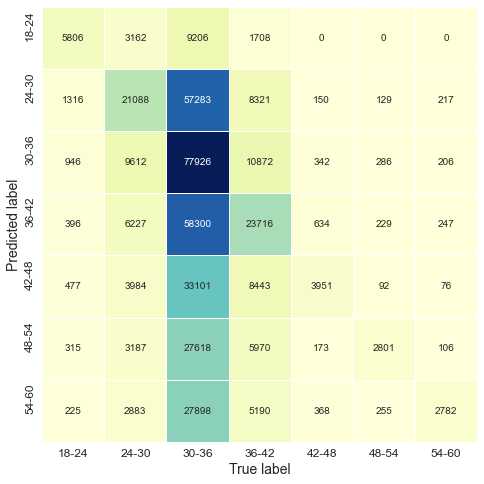

              precision    recall  f1-score   support

           0       0.29      0.61      0.40      9481
           1       0.24      0.42      0.30     50143
           2       0.78      0.27      0.40    291332
           3       0.26      0.37      0.31     64220
           4       0.08      0.70      0.14      5618
           5       0.07      0.74      0.13      3792
           6       0.07      0.77      0.13      3634

    accuracy                           0.32    428220
   macro avg       0.26      0.55      0.26    428220
weighted avg       0.61      0.32      0.37    428220



In [69]:
# predict on test
test_pre = model.predict(test_seq_mat)

# calculate confusion matrix
confm = metrics.confusion_matrix(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1))
# visualization
Labname = ["18-24","24-30","30-36","36-42","42-48","48-54","54-60"]
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(7)+0.5, Labname, size = 12)
plt.yticks(np.arange(7)+0.3, Labname, size = 12)
plt.show()


print(metrics.classification_report(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1)))

# 8. Exploration: NLP on Position 'jobtitle'

The clearing process of 'jobtitle' is similar to 'major' in education in majority.

However, an interesting thing is, there are strange '_|_' in the text. Let's pick it up and find out what's that for.

Unluckily, the NLP outcome is pretty bad (around 0.3 accuracy). However, the model based on job description is much better than the model based on education backgroud.

Here, same as in the education background, I present the process, and show what could be if we have more data.

## 8.1. Data Clean

In [70]:
# pick the major text data
titles = position_new[['user_id', 'jobtitle', 'startdate']].copy()
titles[['title','industry']] = titles.jobtitle.str.split("_\|_", 1, expand=True)

147


<AxesSubplot:>

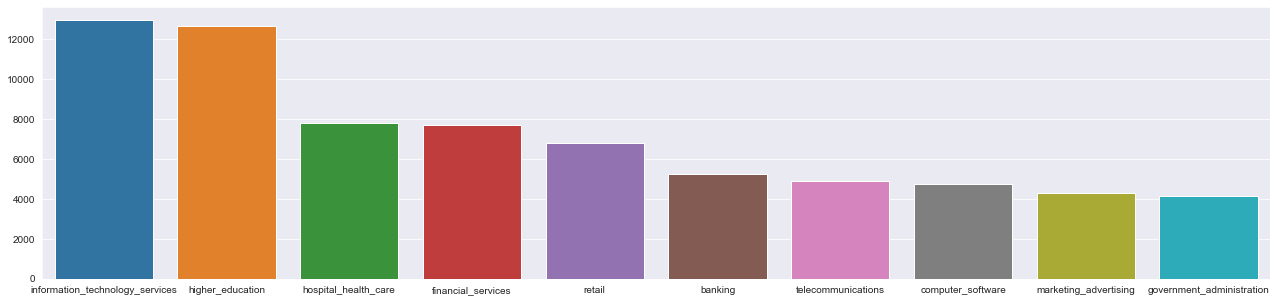

In [71]:
words_count = titles.industry.str.split(expand=True).stack().value_counts()
print(len(words_count))
#print(top10words)
top10words = words_count[:10]
plt.figure(figsize=(22,5))
sns.barplot(top10words.index, top10words)

Industry information has little value on year prediction. The thing that values are the actual titles.

So we can ignore the industry information, and focus on the titles.

In [72]:
titles['title'] = titles['title'].str.lower()
titles['title'] = titles['title'].str.replace('[^a-zA-Z\s]', ' ')
titles = titles.drop(['jobtitle', 'industry'], axis=1)

In [73]:
train_id = completes['user_id'].copy()
job_nlp_train = titles[titles['user_id'].isin(train_id)]
job_nlp_train.sort_values(['user_id', 'startdate'], inplace=True)
job_nlp_train = job_nlp_train.copy().drop(['startdate'], axis=1)
job_nlp_train.dropna(inplace=True)
job_nlp_train['words'] = job_nlp_train.groupby('user_id').transform(lambda x: ''.join(x))
job_nlp_train.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [74]:
job_nlp_train['totalwords'] = job_nlp_train['words'].str.split().str.len()
#job_nlp_train

## 8.2. Check the results of cleaning

52324


<AxesSubplot:>

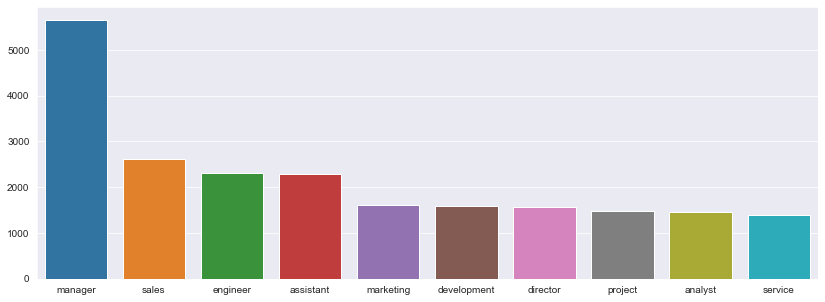

In [75]:
words_count = job_nlp_train.words.str.split(expand=True).stack().value_counts()
print(len(words_count))
#print(top10words)
top10words = words_count[:10]
plt.figure(figsize=(14,5))
sns.barplot(top10words.index, top10words)

count    22563.000000
mean         9.229890
std          8.109826
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        379.000000
Name: totalwords, dtype: float64


Text(0.5, 1.0, 'Majors Words Conbined By Startdate')

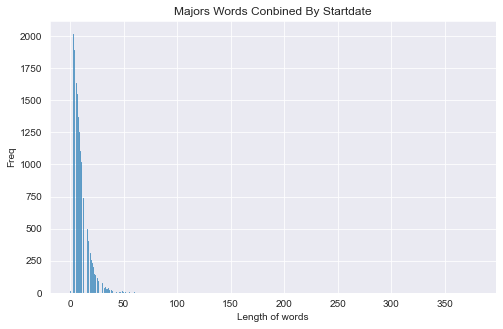

In [76]:
print(job_nlp_train.totalwords.describe())
plt.figure(figsize=(8, 5))
sns.histplot(job_nlp_train.totalwords)
plt.xlabel("Length of words")
plt.ylabel("Freq")
plt.title("Majors Words Conbined By Startdate")

In [77]:
# join the training set
labels = completes[['user_id', 'label']]
job_nlp_train = pd.merge(job_nlp_train, labels, left_on='user_id', right_on='user_id', how='left')

## 8.3. Draw some train/val/test

In [78]:
from sklearn.model_selection import train_test_split

# define dataset and summarize class distribution
X, y = job_nlp_train[['user_id', 'words']], job_nlp_train.iloc[:, -1]
#print(Counter(y))
#X = StandardScaler().fit_transform(X)
#print(X)

# define over/under sampling strategy
over_stra = {1: 1000, 6: 2000, 7: 2000}
under_stra = {3: 5000}
over = RandomOverSampler(sampling_strategy=over_stra)
under = RandomUnderSampler(sampling_strategy=under_stra)

# fit and apply the transform
X, y = over.fit_resample(X, y)
#print(Counter(y))
X, y = under.fit_resample(X, y)
#print(Counter(y))

# increase the data volumn
over_stra = {1: 100000, 2: 443200, 3: 500000, 4: 449300, 5: 248600, 6: 200000, 7: 200000}
over = RandomOverSampler(sampling_strategy=over_stra)
X, y = over.fit_resample(X, y)
print(Counter(y))

# split to trian/val/test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.25, random_state=1)

Counter({3: 500000, 4: 449300, 2: 443200, 5: 248600, 6: 200000, 7: 200000, 1: 100000})


## 8.4. Encoding labels

In [79]:
# reshape
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
val_y = le.transform(val_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

# one-hot
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
val_y = ohe.transform(val_y).toarray()
test_y = ohe.transform(test_y).toarray()

## 8.5. Tokenization

In [80]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

# tokenize
text = job_nlp_train.words.str.cat(sep=' ')
tokens = word_tokenize(text)

# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]

# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]

# filter out stop words
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
#print(words[:100])

# stemming of words
porter = PorterStemmer()
stemmed = [porter.stem(word) for word in words]
print(stemmed[:100])

['center', 'manag', 'faculti', 'sport', 'reportermanagereditor', 'respons', 'sale', 'marketingfilm', 'critic', 'featur', 'writergraph', 'report', 'group', 'leaderair', 'editornew', 'editor', 'redakt', 'reditor', 'redakt', 'r', 'redaktionssekret', 'rredaktionschef', 'chief', 'editor', 'tv', 'newsnyhedschef', 'head', 'newsadvisor', 'r', 'dgiversenior', 'advisor', 'gener', 'servic', 'telleraccount', 'assistantservic', 'offic', 'junior', 'assist', 'managermarket', 'offic', 'junior', 'assist', 'managerrelationship', 'offic', 'call', 'center', 'repres', 'residenti', 'assist', 'commun', 'advisorbid', 'dolphin', 'mentorvolunt', 'tutorcorp', 'member', 'commissari', 'manag', 'andov', 'annual', 'fund', 'student', 'callerdorm', 'cleanup', 'crewpet', 'nurs', 'assistanttenni', 'instructorinternchalleng', 'unlimit', 'volunteersmal', 'anim', 'emerg', 'surgeri', 'night', 'technician', 'mathemat', 'teacherag', 'classroom', 'teacherinstruct', 'facilit', 'assist', 'directordean', 'administr', 'gastoniaear

In [81]:
# we only use the first 500 words to get rid of the strange major like "god"
max_words = 2000
max_len = 20
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(stemmed)

# check the encoding of each word
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break

print("===================")

# check the frequency of each word
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('manag', 1)
('engin', 2)
('sale', 3)
('assist', 4)
('servic', 5)
('develop', 6)
('market', 7)
('account', 8)
('director', 9)
('project', 10)
('center', 254)
('manag', 6727)
('faculti', 62)
('sport', 124)
('reportermanagereditor', 1)
('respons', 58)
('sale', 2637)
('marketingfilm', 1)
('critic', 18)
('featur', 18)


## 8.6. Create the vectors with the encodings and with same length

In [82]:
# to encoding
train_seq = tok.texts_to_sequences(train_X.words)
val_seq = tok.texts_to_sequences(val_X.words)
test_seq = tok.texts_to_sequences(test_X.words)

# adjust length
train_seq_mat = sequence.pad_sequences(train_seq, maxlen=max_len)
val_seq_mat = sequence.pad_sequences(val_seq, maxlen=max_len)
test_seq_mat = sequence.pad_sequences(test_seq, maxlen=max_len)

# show results
print(train_seq_mat.shape)
print(val_seq_mat.shape)
print(test_seq_mat.shape)

(1284660, 20)
(428220, 20)
(428220, 20)


## 8.7. Build LSTM & Train

In [83]:
# define LSTM
inputs = Input(name='inputs', shape=[max_len])

# Embedding (size of token, size of batch, size of words)
layer = Embedding(max_words + 1, 256, input_length=max_len)(inputs)
layer = LSTM(256)(layer)
layer = Dense(256, activation="relu", name="FC1")(layer)
layer = Dropout(0.5)(layer)
layer = Dense(7, activation="softmax", name="FC2")(layer)
model = Model(inputs=inputs, outputs=layer)
print(model.summary())
model.compile(loss="categorical_crossentropy", optimizer=Nadam(), metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 20)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 20, 256)           512256    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 FC1 (Dense)                 (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 FC2 (Dense)                 (None, 7)                 1799      
                                                                 
Total params: 1,105,159
Trainable params: 1,105,159
Non-tra

In [84]:
model_fit = model.fit(train_seq_mat, train_y, batch_size=128, epochs=10,
                      validation_data=(val_seq_mat,val_y),
                      callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)] # when val-loss stop raising, stop the training
                     )

Epoch 1/10
10037/10037 [==============================] - 540s 54ms/step - loss: 1.0095 - accuracy: 0.5843 - val_loss: 0.7035 - val_accuracy: 0.7018
Epoch 2/10
10037/10037 [==============================] - 1133s 113ms/step - loss: 0.7010 - accuracy: 0.7008 - val_loss: 0.6769 - val_accuracy: 0.7077


## 8.8. Predict on Test Set

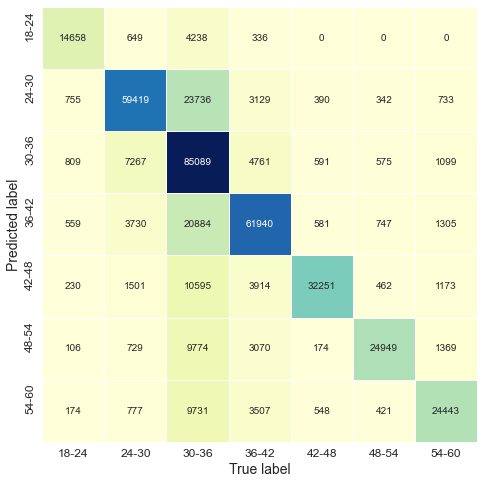

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     17291
           1       0.67      0.80      0.73     74072
           2       0.85      0.52      0.64    164047
           3       0.69      0.77      0.73     80657
           4       0.64      0.93      0.76     34535
           5       0.62      0.91      0.74     27496
           6       0.62      0.81      0.70     30122

    accuracy                           0.71    428220
   macro avg       0.69      0.80      0.73    428220
weighted avg       0.74      0.71      0.70    428220



In [85]:
# predict on test
test_pre = model.predict(test_seq_mat)

# calculate confusion matrix
confm = metrics.confusion_matrix(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1))

# visualization
Labname = ["18-24","24-30","30-36","36-42","42-48","48-54","54-60"]
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(7)+0.5, Labname, size = 12)
plt.yticks(np.arange(7)+0.3, Labname, size = 12)
plt.show()

print(metrics.classification_report(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1)))

# 9. Final Prediction

Since we have shown the superiority of our random forest model comparing with any other model, we can use the results from RF as our final results.

A problem remains: in the 1st round of data cleaning, we drop some row with very little infromation. What should we do to them?

There are 2 possible way:
1. Impute by some value;
2. Leave it be.

Since I am not sure if this project allows the prediciont to be "don't know", and we do have a imputing reason (impute by the mid, though it's a little bit weak), I choose to impute.

## 9.1. Output results

In [86]:
def age_label(x):
    if x == 1:
        return "18-24"
    if x == 2:
        return "24-30"
    if x == 3:
        return "30-36"
    if x == 4:
        return "36-42"
    if x == 5:
        return "42-48"
    if x == 6:
        return "48-54"
    if x == 7:
        return "54-60"

In [87]:
predicted_id = linkedin_impute['user_id'].copy()
d = {'user_id': predicted_id, 'group': rf_predict}
res = pd.DataFrame(data=d)

res = res.merge(completes[['user_id', 'label']], left_on='user_id', right_on='user_id', how='left')

res['true_or_predicted'] = res.label.notna()
res['true_or_predicted'] = res['true_or_predicted'].astype(str)
res['true_or_predicted'] = res['true_or_predicted'].replace('False', 'predicted')
res['true_or_predicted'] = res['true_or_predicted'].replace('True', 'true')

res.label[res.label.isna()] = res.group
res.label = res.label.astype(int)
res['age'] = res.group.apply(lambda x: age_label(x))
res.drop(columns=['group', 'label'], inplace=True)
res = res.sort_values(['true_or_predicted', 'age'])

## 9.2. Visualization

<AxesSubplot:ylabel='age'>

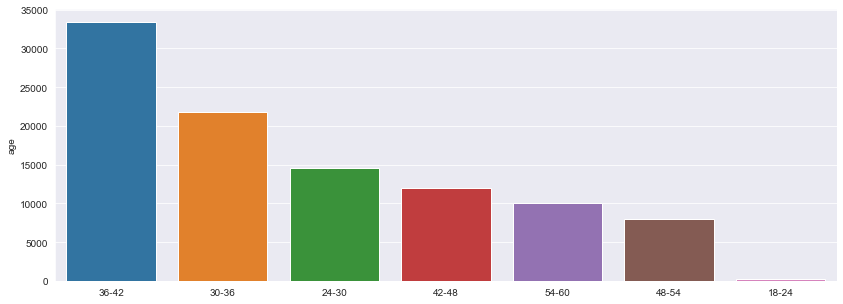

In [88]:
# visualization
words_count = res.age.value_counts()
plt.figure(figsize=(14,5))
sns.barplot(words_count.index, words_count)

In [89]:
# output the results
res.to_csv('res.csv', index=False)

# Future Works

1. For original data
   1. We can increase the amount of data to increase the possible prediction outcomes of all our models;
   2. We can increase the number of original features (like adding a column in education indicating the language) to further pre-process our text;
   3. We can use more detailed 1st-round cleaning strategies to clean our data.
2. For trianing set
   1. We can try different numbers of training sets to build our models;
   2. We can try different selecting method for "ground truth";
   3. We can combine different "ground truth" to train our models.
3. For random forest
   1. We can try to eliminate some of the features before we throw them directly into the model;
   2. We can use a denser grid-search in optimization;
   3. We can use use a combination of different classification models on the same training set.
4. For NLP models
   1. We should translate the text other than English (in this draft it's limited by computational power and API efficiency);
   2. We can have more detailed text cleaning strategies (like specification of useless text, such as 'god' as 'major');
   3. We can make our network more complex;
   4. We can use improved version of LSTM, such as BERT/Q-BERT;
5. For final predictions
   1. We **should combine the predictions from our models based on numbers (such as random forest) and our models based on text (such as LSTM)**;
   2. We should have a better solution to the users that we really can not predict anything (like just drop them);
   3. We should have some test on the age group definition (like, set the intervals to 4, set the intervals between 24-42 denser, etc.)；
   4. We should have a better strategy to deal with the minor group (like 18-24).